![alt text](flowersbanner.png)


# Model and Training Notebook
This notebook demonstrates the process of building, training, and evaluating a machine learning model for computer vision for image classification for different flower types. The steps include data loading, model construction, training, and evaluation.

The dataset we are working with consists of 16 different flower types.

### Importing necessary libraries

In [7]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


### Data Loading
In this cell, we load the dataset, create the training and validation splits and show a couple random images from our dataset to see what the model will be fed with. 

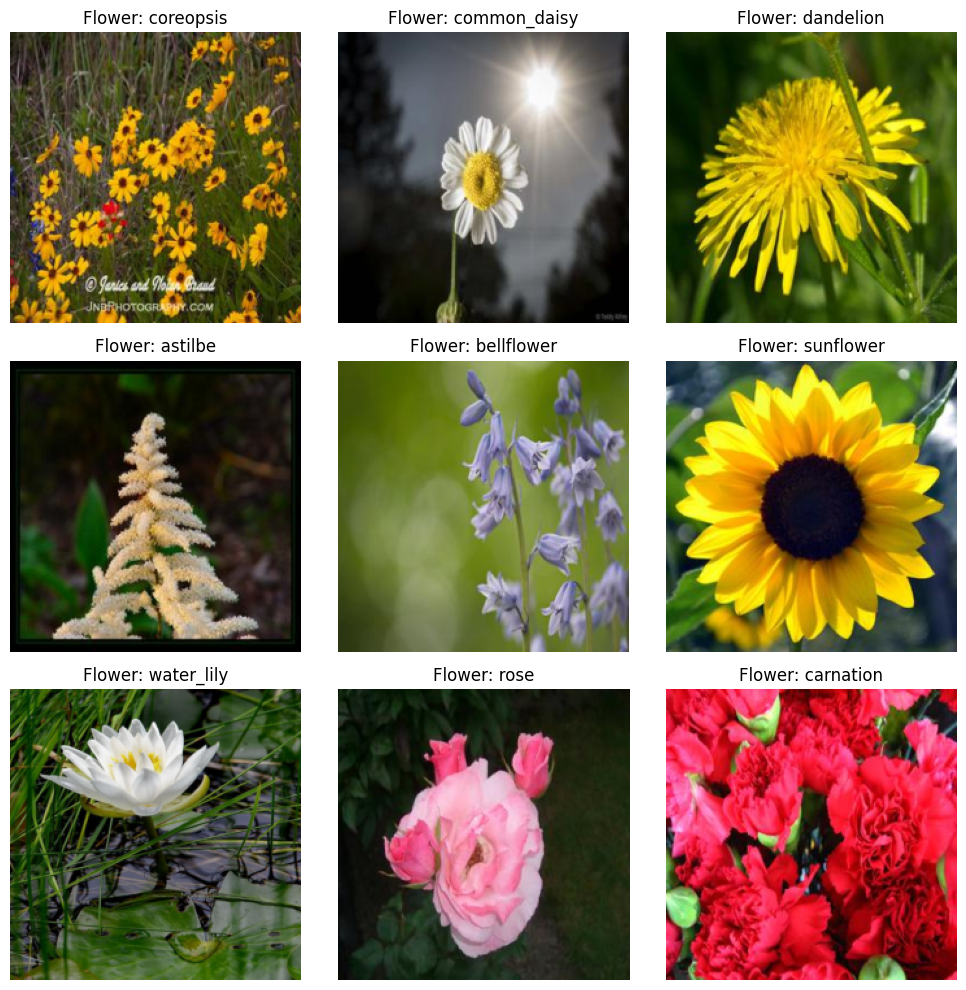

In [2]:
# Define transforms for the images (you can add more augmentation as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fixed size if needed
    transforms.ToTensor(),
])

# Load the dataset using ImageFolder
dataset = ImageFolder(root='Flower Dataset', transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size=100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

# Function to show random images
def show_random_images(dataset, class_names, ncols=3):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    random_indices = random.sample(range(len(dataset)), 9)
    
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # (C, H, W) to (H, W, C)
        ax = axes.flat[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Flower: {class_names[label]}')
    
    plt.tight_layout()
    plt.show()

# Display random images with labels
show_random_images(train_dataset, dataset.classes)


### Definition of the model
Here we define the model that will be trained. It's a convolutional neural network with relu functions as activations.

In [3]:
class FlowerCNN(nn.Module):
    def __init__(self, num_classes):
        super(FlowerCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) #we have 3 in channels since we have 3 color rgb. 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 2048)  # Adjust input size based on your actual feature map size
        self.fc2 = nn.Linear(2048,1024)
        self.fc3 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Parameters
Here we define the parameters that will be used for training the model such as the optimizer and the loss function.

In [4]:
num_classes = len(dataset.classes)  # Number of classes is based on the dataset
model = FlowerCNN(num_classes)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001) #We will use the Adam optimizer in this case. 
print(model)

FlowerCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=16, bias=True)
)


### Training and evaluation functions
Here we define the training and evaluation functions that will be used for training and evaluating the model.

In [5]:
def train_model(model, optimizer, loss_fn, train_loader, test_loader, epochs=10):
    total_train_images = len(train_loader.dataset)
    loglosses=[]
    precisions=[]
    for epoch in range(epochs):
        running_loss = 0.0
        total_processed=0
        
        # Training phase
        model.train()  # Set the model to training mode
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            total_processed += batch_size

            if i % 10 == 9:    # Print every 10 mini-batches
                avg_loss = running_loss / 10
                print(f'Training: Epoch [{epoch + 1}, {total_processed}/{total_train_images} ({total_processed / total_train_images * 100:.2f}%)] Loss: {avg_loss:.3f}')
                running_loss = 0.0
        
        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, loss_fn, test_loader)
        print(f'End of Epoch {epoch + 1}. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        loglosses.append(val_loss)
        precisions.append(val_accuracy)
    
    print('Finished Training')
    return loglosses, precisions

# Assuming evaluate_model function is defined as per previous discussions
def evaluate_model(model, loss_fn, data_loader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy

### Training the model
Now we train the model, saving the accuracies and losses to analyze them afterwards. 

In [6]:
losses,precision=train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10)

Training: Epoch [1, 1000/12592 (7.94%)] Loss: 2.782
Training: Epoch [1, 2000/12592 (15.88%)] Loss: 2.765
Training: Epoch [1, 3000/12592 (23.82%)] Loss: 2.753
Training: Epoch [1, 4000/12592 (31.77%)] Loss: 2.578
Training: Epoch [1, 5000/12592 (39.71%)] Loss: 2.346
Training: Epoch [1, 6000/12592 (47.65%)] Loss: 2.295
Training: Epoch [1, 7000/12592 (55.59%)] Loss: 2.218
Training: Epoch [1, 8000/12592 (63.53%)] Loss: 2.173
Training: Epoch [1, 9000/12592 (71.47%)] Loss: 2.096
Training: Epoch [1, 10000/12592 (79.42%)] Loss: 2.010
Training: Epoch [1, 11000/12592 (87.36%)] Loss: 1.956
Training: Epoch [1, 12000/12592 (95.30%)] Loss: 1.964
End of Epoch 1. Validation Loss: 1.8532, Validation Accuracy: 0.3434
Training: Epoch [2, 1000/12592 (7.94%)] Loss: 1.848
Training: Epoch [2, 2000/12592 (15.88%)] Loss: 1.814
Training: Epoch [2, 3000/12592 (23.82%)] Loss: 1.768
Training: Epoch [2, 4000/12592 (31.77%)] Loss: 1.777
Training: Epoch [2, 5000/12592 (39.71%)] Loss: 1.746
Training: Epoch [2, 6000/1259

### Analyzing the results
In this cell we plot the results. 

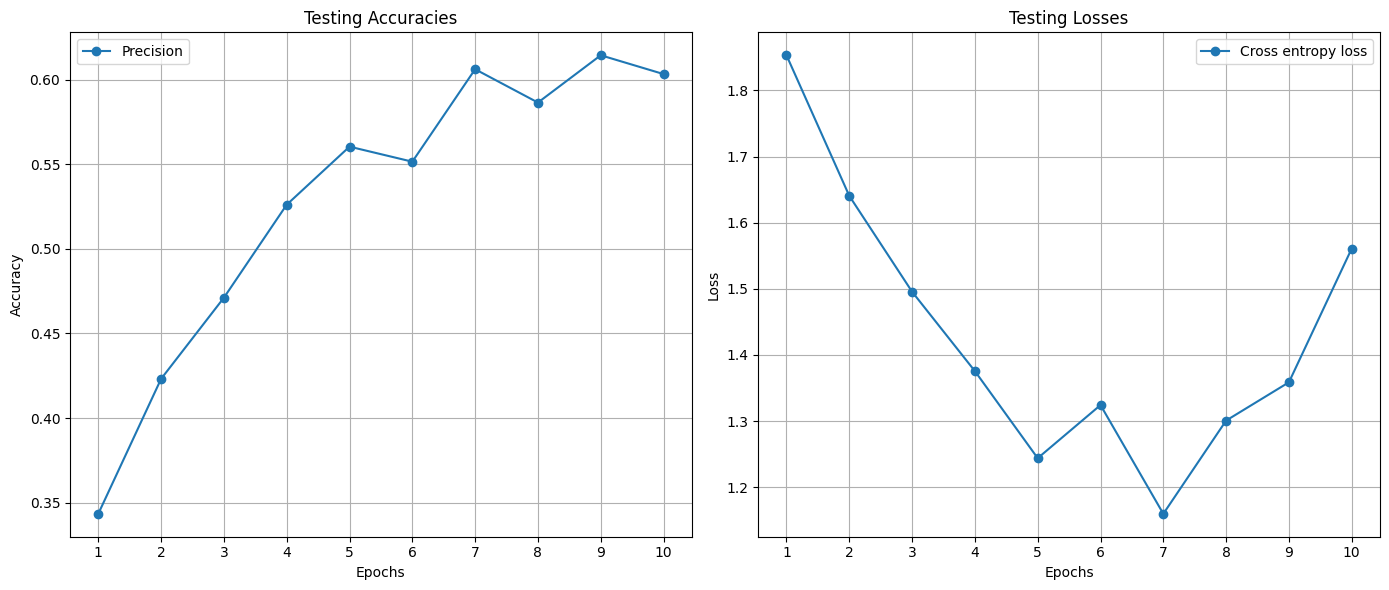

In [10]:
epochs=10
# Create a figure and a set of subplots
x=np.linspace(1,10,10)

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracies
ax1.plot(x, precision, label='Precision', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Testing Accuracies')
ax1.grid(True)
ax1.legend()
ax1.set_xticks(np.arange(1, epochs + 1))  # Set ticks at every integer point from 1 to epochs

# Plot losses
ax2.plot(x, losses, label='Cross entropy loss', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Testing Losses')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(np.arange(1, epochs + 1))  # Set ticks at every integer point from 1 to epochs

# Adjust layout for a better fit
plt.tight_layout()

# Show the plot
plt.show()

### Conclusion

As we can see, the model predicts well on 60% of the cases. While it's not a perfect model, we have to take into account that the images weren't extremely clear, which may lead to the model underperforming. 
Furthermore, 60% accuracy for 16 different classes is not that bad either. 

Further improvements and comparisons could be pretraining a model like ResNet18 on our dataset and compare its performance with the model we created. 